<a href="https://colab.research.google.com/github/itberrios/think_autonomous/blob/main/neural_optimization_course%20/Static_Quantization_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to the Quantization Workshop

In this workshop, we'll learn how to ***Quantize CNN-based architectures to make them 4x smaller and 2x faster in Pytorch***

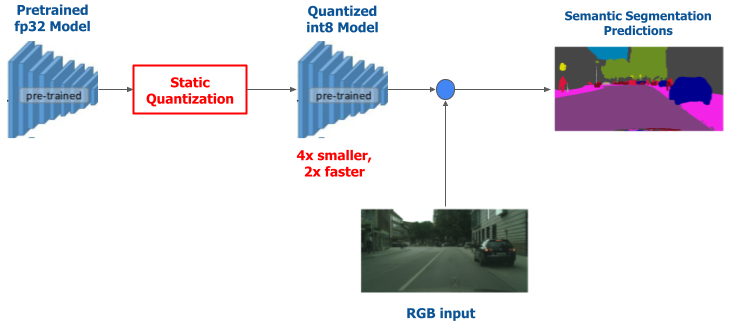

Specifically, we'll do the following:

1. **Dataset** — Load and visualize Cityscapes dataset
2. **Model** — Load pretrained fp32 model and evaluate test metric
3. **Quantization** — Static Quantization of pre-trained model
4. **Results** — Performance comparison between Normal vs Quantized model

### Imports

In [1]:
!wget https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/quantization_content.zip && unzip -q quantization_content.zip && rm quantization_content.zip

--2023-05-23 00:03:04--  https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/quantization_content.zip
Resolving optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)... 52.95.155.44
Connecting to optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)|52.95.155.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 544242167 (519M) [application/zip]
Saving to: ‘quantization_content.zip’

quantization_conten 100%[===================>] 519.03M  13.9MB/s    in 39s     

2023-05-23 00:03:44 (13.5 MB/s) - ‘quantization_content.zip’ saved [544242167/544242167]



In [38]:
# Basic imports
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# DL imports 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore") 

## 1. Dataset
We're going to use the [Cityscapes Dataset](https://www.cityscapes-dataset.com/). Here is how it goes:

- **Input: 3-channel RGB image** of resolution (256 x 512)
- **Output: 1-channel image** of resolution (256 x 512)
* There are **19 classes** for semantic segmentation
- The Pytorch Dataset for the task is already defined and it returns a mask (an image)

In [39]:
from scripts.helper import cityScapeDataset

In [40]:
NUM_CLASSES = 19
IGNORE_INDEX = 255

# Convert to torch tensor and normalize images using Imagenet values
tf = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

TEST_BATCH_SIZE  = 8

# Creating Test set and Test Dataloaders
test_set = cityScapeDataset(rootDir= 'semSeg_256_512', folder='val', tf = tf)
test_set = torch.utils.data.Subset(test_set, indices=np.arange(40))
test_dataloader  = DataLoader(test_set, batch_size=TEST_BATCH_SIZE)

Let's verify size of images from the dataset

In [41]:
rgb_image, label_image = test_set[0]
print(f"There are {len(test_set)} test Images")
print(f"Input shape = {rgb_image.numpy().shape}, output label shape = {label_image.numpy().shape}")

There are 40 test Images
Input shape = (3, 256, 512), output label shape = (256, 512)


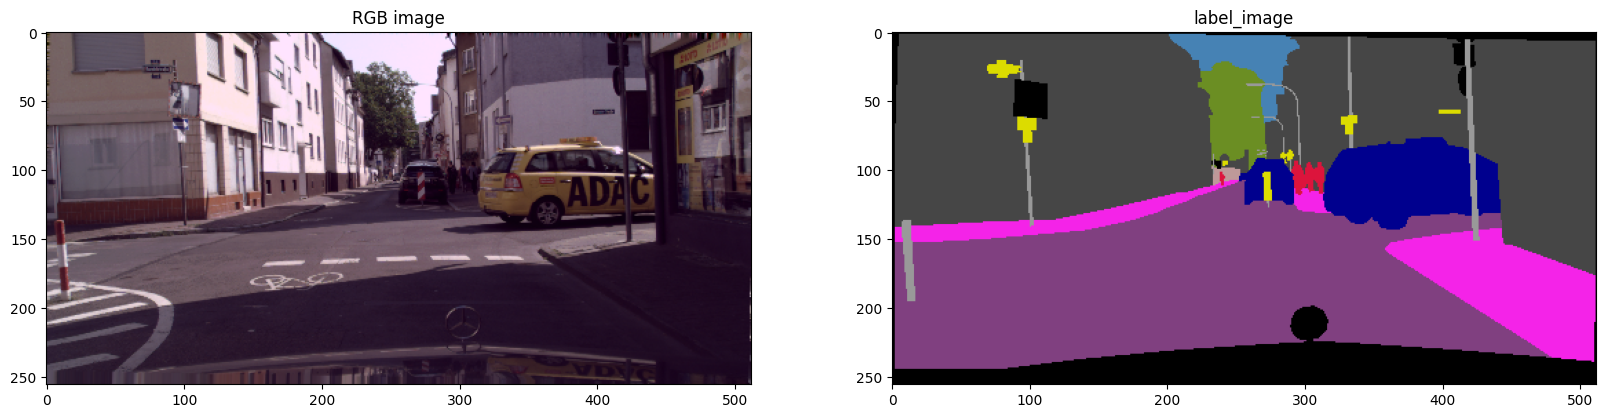

In [42]:
from scripts.helper import inverse_transform, decodeTarget        
        
source_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy() # From Normalized to RGB
colormapped_label_image = decodeTarget(label_image).astype('uint8')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 40))
ax1.imshow(source_image)
ax1.set_title("RGB image")
ax2.imshow(colormapped_label_image)
ax2.set_title("label_image")
plt.show()

## 2. Model

We're going to use a [DeepLabv3 model](https://github.com/pytorch/vision/tree/main/torchvision/models/segmentation)  with a ResNet50 backbone.

First, let's compare the classic DeepLabv3 vs the one we'll use.

<table>
<tr>
<th> Original BottleNeck block </th>
<th> Quantized BottleNeck block </th>
</tr>
<tr>
<td>

```python
class Bottleneck(nn.Module):
    expansion: int = 4
    def __init__(self, inplanes: int, planes: int, stride: int = 1, 
                 downsample: Optional[nn.Module] = None, groups: int = 1,
                 base_width: int = 64, dilation: int = 1, 
                 norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups

        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)

        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)

        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

```

</td>
<td>

```python
class Bottleneck(nn.Module):
    expansion: int = 4
    def __init__(self, inplanes: int, planes: int, stride: int = 1, 
                downsample: Optional[nn.Module] = None, groups: int = 1,
                base_width: int = 64, dilation: int = 1, 
                norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        # RELU MODULES ARE NUMBERED INDIVIDUALLY INSTEAD OF COMMON ONE
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        # RELU MODULES ARE NUMBERED INDIVIDUALLY INSTEAD OF COMMON ONE
        self.relu2 = nn.ReLU(inplace=True)
        
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)        
        self.downsample = downsample
        # SEPARATE MODULE FOR QUANTIZED ADDITION
        self.skip_add = nn.quantized.FloatFunctional()
        # RELU MODULES ARE NUMBERED INDIVIDUALLY INSTEAD OF COMMON ONE
        self.relu3 = nn.ReLU(inplace=True)
        self.stride = stride
```

</td>
</tr>
</table>

In [43]:
from scripts.helper import meanIoU

In [44]:
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

# import model class
from scripts.models.segmentation import deeplabv3_resnet50

# load pretrained model and transfer to CPU, set to inference mode
fp32_model = deeplabv3_resnet50(pretrained=False, num_classes=NUM_CLASSES)
fp32_model.load_state_dict(torch.load('weightFiles/deeplabv3_r50.pt', map_location=cpu_device))
fp32_model.eval()

# evaluate performance on Test set
from scripts.helper import evaluteOnTestData
fp32_model_metric = evaluteOnTestData(fp32_model, None, gpu_device, test_dataloader, meanIoU, 'meanIoU', 'fp32_model_deepLabv3')
print(f"\nfp32_model has {round(fp32_model_metric,3)} IoU metric on test data")

100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


fp32_model has 0.559 IoU metric on test data


Let's visualize the predictions of model output

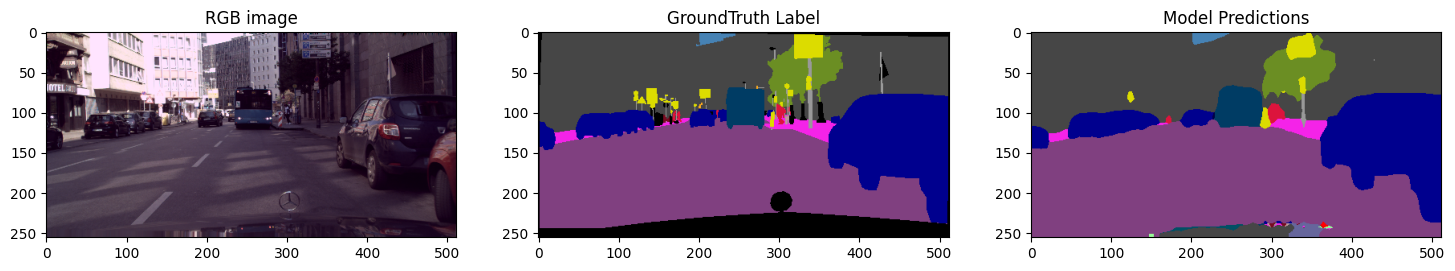

In [45]:
from scripts.helper import visualizePredictions
visualizePredictions(fp32_model, test_set, cpu_device, 1)

We are going to save the pretrained model in JIT format.

In [46]:
## Save scripted version of the fp32 model, and load it for benchmarking

#TODO: Save in JIT Format under the name "weightFiles/fp32_jit_deeplabv3.pt"

m = torch.jit.script(fp32_model)
torch.jit.save(m, "weightFiles/fp32_jit_deeplabv3.pt")

fp32_jit_model = torch.jit.load('weightFiles/fp32_jit_deeplabv3.pt', map_location = cpu_device)

## 3. Static Quantization of pre-trained model
Here's how it happens, starting with an FP32 Model:
1. Module Fusion — Conv+BatchNorm+ReLU
2. Formula Definition
3. Select a Deployment Environment
4. Calibrate on the Dataset
5. Convert to Int8

#### Starting from an FP32 Model

In [47]:
from copy import deepcopy
model_to_quantize = deepcopy(fp32_model)
model_to_quantize.eval();
model_to_quantize.to(cpu_device);

In [48]:
print(fp32_model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

#### 1. Module Fusion — Conv+BN+RELU

In [61]:
modules_to_fuse = [
        ['backbone.conv1', 'backbone.bn1', 'backbone.relu'],

        ['backbone.layer1.0.conv1', 'backbone.layer1.0.bn1', 'backbone.layer1.0.relu1'],
        ['backbone.layer1.0.conv2', 'backbone.layer1.0.bn2', 'backbone.layer1.0.relu2'],
        ['backbone.layer1.0.conv3', 'backbone.layer1.0.bn3'],
        ['backbone.layer1.0.downsample.0', 'backbone.layer1.0.downsample.1'],

        ['backbone.layer1.1.conv1', 'backbone.layer1.1.bn1', 'backbone.layer1.1.relu1'],
        ['backbone.layer1.1.conv2', 'backbone.layer1.1.bn2', 'backbone.layer1.1.relu2'],
        ['backbone.layer1.1.conv3', 'backbone.layer1.1.bn3'],

        ['backbone.layer1.2.conv1', 'backbone.layer1.2.bn1', 'backbone.layer1.2.relu1'],
        ['backbone.layer1.2.conv2', 'backbone.layer1.2.bn2', 'backbone.layer1.2.relu2'],
        ['backbone.layer1.2.conv3', 'backbone.layer1.2.bn3'],

        ['backbone.layer2.0.conv1', 'backbone.layer2.0.bn1', 'backbone.layer2.0.relu1'],
        ['backbone.layer2.0.conv2', 'backbone.layer2.0.bn2', 'backbone.layer2.0.relu2'],
        ['backbone.layer2.0.conv3', 'backbone.layer2.0.bn3'],
        ['backbone.layer2.0.downsample.0', 'backbone.layer2.0.downsample.1'],

        ['backbone.layer2.1.conv1', 'backbone.layer2.1.bn1', 'backbone.layer2.1.relu1'],
        ['backbone.layer2.1.conv2', 'backbone.layer2.1.bn2', 'backbone.layer2.1.relu2'],
        ['backbone.layer2.1.conv3', 'backbone.layer2.1.bn3'],

        ['backbone.layer2.2.conv1', 'backbone.layer2.2.bn1', 'backbone.layer2.2.relu1'],
        ['backbone.layer2.2.conv2', 'backbone.layer2.2.bn2', 'backbone.layer2.2.relu2'],
        ['backbone.layer2.2.conv3', 'backbone.layer2.2.bn3'],

        ['backbone.layer2.3.conv1', 'backbone.layer2.3.bn1', 'backbone.layer2.3.relu1'],
        ['backbone.layer2.3.conv2', 'backbone.layer2.3.bn2', 'backbone.layer2.3.relu2'],
        ['backbone.layer2.3.conv3', 'backbone.layer2.3.bn3'],

        ['backbone.layer3.0.conv1', 'backbone.layer3.0.bn1', 'backbone.layer3.0.relu1'],
        ['backbone.layer3.0.conv2', 'backbone.layer3.0.bn2', 'backbone.layer3.0.relu2'],
        ['backbone.layer3.0.conv3', 'backbone.layer3.0.bn3'],
        ['backbone.layer3.0.downsample.0', 'backbone.layer3.0.downsample.1'],

        ['backbone.layer3.1.conv1', 'backbone.layer3.1.bn1', 'backbone.layer3.1.relu1'],
        ['backbone.layer3.1.conv2', 'backbone.layer3.1.bn2', 'backbone.layer3.1.relu2'],
        ['backbone.layer3.1.conv3', 'backbone.layer3.1.bn3'],

        ['backbone.layer3.2.conv1', 'backbone.layer3.2.bn1', 'backbone.layer3.2.relu1'],
        ['backbone.layer3.2.conv2', 'backbone.layer3.2.bn2', 'backbone.layer3.2.relu2'],
        ['backbone.layer3.2.conv3', 'backbone.layer3.2.bn3'],

        ['backbone.layer3.3.conv1', 'backbone.layer3.3.bn1', 'backbone.layer3.3.relu1'],
        ['backbone.layer3.3.conv2', 'backbone.layer3.3.bn2', 'backbone.layer3.3.relu2'],
        ['backbone.layer3.3.conv3', 'backbone.layer3.3.bn3'],

        ['backbone.layer3.4.conv1', 'backbone.layer3.4.bn1', 'backbone.layer3.4.relu1'],
        ['backbone.layer3.4.conv2', 'backbone.layer3.4.bn2', 'backbone.layer3.4.relu2'],
        ['backbone.layer3.4.conv3', 'backbone.layer3.4.bn3'],

        ['backbone.layer3.5.conv1', 'backbone.layer3.5.bn1', 'backbone.layer3.5.relu1'],
        ['backbone.layer3.5.conv2', 'backbone.layer3.5.bn2', 'backbone.layer3.5.relu2'],
        ['backbone.layer3.5.conv3', 'backbone.layer3.5.bn3'],

        ['backbone.layer4.0.conv1', 'backbone.layer4.0.bn1', 'backbone.layer4.0.relu1'],
        ['backbone.layer4.0.conv2', 'backbone.layer4.0.bn2', 'backbone.layer4.0.relu2'],
        ['backbone.layer4.0.conv3', 'backbone.layer4.0.bn3'],
        ['backbone.layer4.0.downsample.0', 'backbone.layer4.0.downsample.1'],

        ['backbone.layer4.1.conv1', 'backbone.layer4.1.bn1', 'backbone.layer4.1.relu1'],
        ['backbone.layer4.1.conv2', 'backbone.layer4.1.bn2', 'backbone.layer4.1.relu2'],
        ['backbone.layer4.1.conv3', 'backbone.layer4.1.bn3'],

        ['backbone.layer4.2.conv1', 'backbone.layer4.2.bn1', 'backbone.layer4.2.relu1'],
        ['backbone.layer4.2.conv2', 'backbone.layer4.2.bn2', 'backbone.layer4.2.relu2'],
        ['backbone.layer4.2.conv3', 'backbone.layer4.2.bn3'],

        ['classifier.0.convs.0.0', 'classifier.0.convs.0.1', 'classifier.0.convs.0.2'],
        ['classifier.0.convs.1.0', 'classifier.0.convs.1.1', 'classifier.0.convs.1.2'],
        ['classifier.0.convs.2.0', 'classifier.0.convs.2.1', 'classifier.0.convs.2.2'],
        ['classifier.0.convs.3.0', 'classifier.0.convs.3.1', 'classifier.0.convs.3.2'],
        ['classifier.0.convs.4.1', 'classifier.0.convs.4.2', 'classifier.0.convs.4.3'],

        ['classifier.0.project.0', 'classifier.0.project.1', 'classifier.0.project.2'],
        ['classifier.1', 'classifier.2', 'classifier.3']
    ]

In [62]:
#TODO: Fuse the Modules CONV BN RELU
# modules_to_fuse = []

# for name, m in model_to_quantize.named_modules():
#   if 'conv' in name:
#     block = [name]
#   elif ('bn' in name) and (len(block) == 1):
#     block.append(name)
#   elif ('relu' in name) and (len(block) == 2):
#     block.append(name)
#     modules_to_fuse.append(block)
    
#TODO: Invoke torch.quantization.fuse_modules on the model
fused_model = torch.ao.quantization.fuse_modules(model_to_quantize, modules_to_fuse)
print(fused_model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): ConvReLU2d(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU(inplace=True)
    )
    (bn1): Identity()
    (relu): Identity()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): ConvReLU2d(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU(inplace=True)
        )
        (bn1): Identity()
        (relu1): Identity()
        (conv2): ConvReLU2d(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
        (bn2): Identity()
        (relu2): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn3): Identity()
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (1): Identity()
        )

*Effect*
- conv2d modules are converted to ConvRelu2d
- BatchNorm2d and relu modules are converted to Identity

####2. Formula Definition

- Here, we'll define a nn.Module class which will take the floating point model and create stubs for input, output using torch APIs.
- `QuantStub` map the floating point input data to integer
- `DeQuantStub` map the integer model predictions to floating point representation

In [63]:
class quantStubModel(nn.Module):
    def __init__(self, model_fp32):
        super(quantStubModel, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.ao.quantization.QuantStub() #TODO: define the quantization
        
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.ao.quantization.DeQuantStub() #TODO: Define the dequantization
        
        self.model_fp32 = model_fp32

    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        x = self.dequant(x)
        return x

# creating nn.Module with stubs for inputs and outputs
quant_stubbed_model = quantStubModel(model_fp32=fused_model);

####3. Select a Deployment Environment 

3.1. The most important parameter is the **backend selection**.
    - fbgemm — a backend for CPU & Colab Envs
    - qnnpack — a backend for ARM architectures

In [64]:
# colab requires fbgemm backend
use_fbgemm = True

if use_fbgemm == True:
  quantization_config = torch.quantization.get_default_qconfig('fbgemm')
  torch.backends.quantized.engine = 'fbgemm'
  backend = 'fbgemm'

else:
  quantization_config = torch.quantization.default_qconfig
  torch.backends.quantized.engine = 'qnnpack'
  backend = 'qnnpack'

3.2. Select an Observer to "calibrate"
- Pytorch uses an `Observer` to calculate parameters required to approximate a module
- Observer type and its properties can be set using configuration parameters
- When 'quantization.prepare()' function is called, observers are inserted into every module to be quantized.

In [65]:
#TODO:; Configure the quant stubbed model  
#TODO: Call torch.quantization.prepare on the quant_stubbed_model

quant_stubbed_model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.quantization.prepare(m, inplace=True)

Conv2d(256, 19, kernel_size=(1, 1), stride=(1, 1))

As seen in output, `Histogram observers` are the default ones inserted into the modules of the model in fbgemm configuration

#### 4. Calibrate on the Dataset


In [66]:
quantSet = torch.utils.data.Subset(test_set, indices=np.arange(24))
quantDataloader = DataLoader(quantSet, batch_size=TEST_BATCH_SIZE)

with torch.no_grad():
    for inputs, labels in tqdm(quantDataloader):
        inputs, labels = inputs.to(cpu_device), labels.to(cpu_device)
        _ = quant_stubbed_model(inputs)

100%|██████████| 3/3 [00:45<00:00, 15.32s/it]


####5. Convert to Int8 (and save)

In [67]:
#TODO: Call the Convert function
quantized_model = torch.quantization.convert(quant_stubbed_model, inplace=True) 

In [68]:
torch.jit.save(torch.jit.script(quantized_model), 'weightFiles/int8_jit_deepLabv3.pt')

## 4. Results

100%|██████████| 5/5 [01:23<00:00, 16.62s/it]



int8_model has 0.559 IoU metric on test data


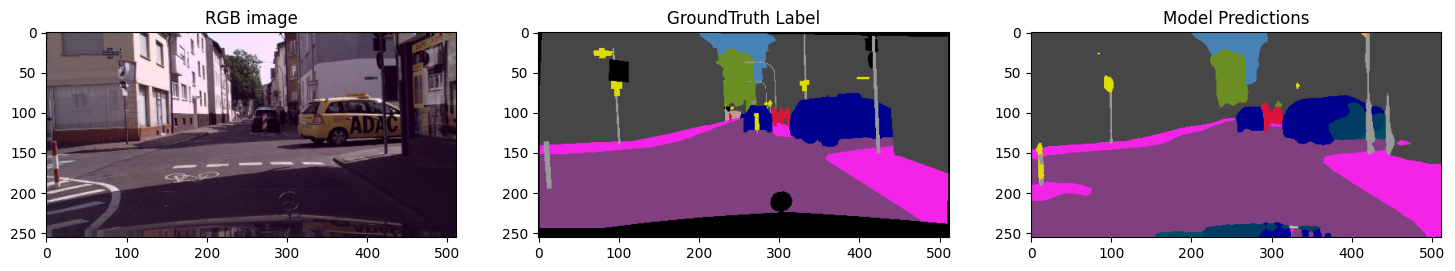

In [69]:
# Load quantized model
int8_jit_model = torch.jit.load('weightFiles/int8_jit_deepLabv3.pt', map_location=cpu_device)

# Evaluate performance on Test set
int8_model_metric = evaluteOnTestData(int8_jit_model, None, cpu_device, test_dataloader, meanIoU, 
                                    'meanIoU', 'int8_model_deepLabv3')
print(f"\nint8_model has {round(int8_model_metric,3)} IoU metric on test data")

# Visualize output predictions
visualizePredictions(int8_jit_model, test_set, cpu_device, 1)

***Inference metrics of fp32 model vs int8 model***

In [70]:
from scripts.modelMetrics import modelMetrics

torch.set_num_threads(1)

_ = modelMetrics(fp32_jit_model, modelName= 'fp32_jit_deeplabv3', 
             input=torch.rand(1,3,256,256), device=cpu_device, verbose=True)

_ = modelMetrics(int8_jit_model, modelName= 'quantized_jit_deeplabv3', 
             input=torch.rand(1,3,256,256), device=cpu_device, verbose=True)

-------------
 Metrics of fp32_jit_deeplabv3 
-------------
Device = cpu
NA MMACs, NA MFLOPs and NA M parameters
Model FileSize = 158.975549 MB
Single batch inference Time of model = 1409.5463752746582 milliseconds
-------------
 Metrics of quantized_jit_deeplabv3 
-------------
Device = cpu
NA MMACs, NA MFLOPs and NA M parameters
Model FileSize = 158.608571 MB
Single batch inference Time of model = 879.815149307251 milliseconds


# Play on Video

Let's play it on a video in Stuttgart!

In [71]:
# utility function to calculate inference time on single frame for given model and input image
def getModelPredInfo(model : nn.Module, input: torch.Tensor, device: torch.device):
    start_time = time.time()
    preds = model(input)
    end_time = time.time()
    
    # calculate model inference time in terms of FPS
    inference_time = end_time - start_time
    FPS = (1.0 / inference_time)
    return preds, FPS

In [72]:
# read input images from demoVideo sequenqce
image_files = sorted(os.listdir('semSeg_256_512/demoVideo/'))
print(f'There are {len(image_files)} images.')

There are 599 images.


In [73]:
def caption_image(image, title, pos, color = (49,49,49)):
    frame = np.ones((50, 516, 3), np.uint8) * 255
    bordered_image = cv2.copyMakeBorder(image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=(0,0,0))
    image_with_frame = cv2.vconcat((frame, bordered_image))
    cv2.putText(image_with_frame, title, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)
    return image_with_frame

In [ ]:
import time
from tqdm import tqdm

torch.set_num_threads(1)

# set models to inference mode
fp32_jit_model.eval();
int8_jit_model.eval();

# we'll get video of 80 images for time constraints
num_video_images = len(image_files)
result_video = []

# iterate through images
for img_path in tqdm(image_files[0:num_video_images]):
    rgb_image = cv2.cvtColor(cv2.imread(f'semSeg_256_512/demoVideo/{img_path}'), cv2.COLOR_BGR2RGB)
    torch_image = tf(rgb_image).unsqueeze(0).to(cpu_device) 

    # get model predictions, FPS
    fp32_model_preds, fp32_model_fps = getModelPredInfo(fp32_jit_model, torch_image, cpu_device)
    int8_model_preds, int8_model_fps = getModelPredInfo(int8_jit_model, torch_image, cpu_device)
    fps_improvement_percent = ((int8_model_fps / fp32_model_fps) - 1) * 100

    # get class predictions, convert to color map
    fp32_color_preds = decodeTarget(np.argmax(fp32_model_preds.detach().cpu().numpy(), axis=1)[0]).astype(np.uint8)
    int8_color_preds = decodeTarget(np.argmax(int8_model_preds.detach().cpu().numpy(), axis=1)[0]).astype(np.uint8)
    
    captioned_rgb_image = caption_image(rgb_image, 'RGB Image', (200,35));
    captioned_fp32_preds = caption_image(fp32_color_preds, 'Original Model', (150,35))
    captioned_int8_preds = caption_image(int8_color_preds, 'Quantized Model', (70,35))

    # cv2.putText(captioned_int8_preds, f'{fps_improvement_percent : 3.1f}% faster', (320, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (237,42,41), 2, cv2.LINE_AA)
    cv2.putText(captioned_int8_preds, f'{int8_model_fps : 3.1f} FPS', (330, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (237,42,41), 2, cv2.LINE_AA)
    cv2.putText(captioned_fp32_preds, f'{fp32_model_fps : 3.1f} FPS', (330, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (237,42,41), 2, cv2.LINE_AA)
    
    total_frame = cv2.vconcat((cv2.cvtColor(captioned_rgb_image, cv2.COLOR_RGB2BGR), 
                           cv2.cvtColor(captioned_fp32_preds, cv2.COLOR_RGB2BGR),
                           cv2.cvtColor(captioned_int8_preds, cv2.COLOR_RGB2BGR)))
    
    result_video.append(total_frame)

 15%|█▍        | 88/599 [05:21<29:55,  3.51s/it]

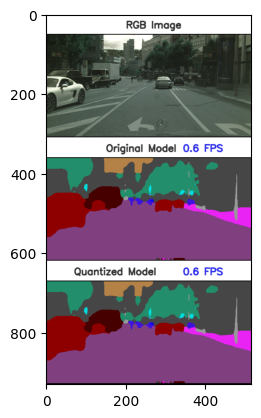

In [93]:
plt.imshow(total_frame)

In [ ]:
out = cv2.VideoWriter('staticQuantizationOutput.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, \
                      (total_frame.shape[1], total_frame.shape[0]))

for img in result_video:
  out.write(img)
out.release()

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('staticQuantizationOutput.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)